# Capacity vs. sampling bias

author: steeve.laquitaine@epfl.ch  

**purpose**: what is effect of this sampling bias on the circuit's information capacity (IC)?
    
**methods**:

* contrast IC b/w random sampling vs. biased sampling.
* We focus on single-units
* multi-units have not one type by definition.
* sample a population of units such that we control number of each unit type (random vs biased), for each sorter

### Setup

Setup `manifold` env

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.features import features as feat
from src.nodes.analysis.code import igeom
from src.nodes.analysis.stats import stats


# SETUP CONFIG
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT = data_conf["sorting"]["simulation"]["ground_truth"]["full"]["output"]
REC = data_conf["probe_wiring"]["output"]
IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]

# SORTINGS
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]
K3 = data_conf["sorting"]["sorters"]["kilosort3"]["full"]["output"]
K25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["full"]["output"]
K2 = data_conf["sorting"]["sorters"]["kilosort2"]["full"]["output"]
KS = data_conf["sorting"]["sorters"]["kilosort"]["full"]["output"]
HS = data_conf["sorting"]["sorters"]["herdingspikes"]["full"]["output"]
IGEOM_SAMP = data_conf["analyses"]["neural_code"]["by_sampling"]["igeom"]
IGEOM_DIM = data_conf["analyses"]["neural_code"]["by_dimensionality"]["igeom"]

# SETUP QUALITY PATH
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False
DT = 1.3

# STATISTICAL PARAMETERS
N_BOOT = 20

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

2024-10-22 10:54:02,850 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-22 10:54:03,168 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [10]:
def get_mean_capacity_for_rand(sorter, igeom_df):

    # full ground truth capacity
    gt_full_cap = np.mean(igeom_df[igeom_df.Sorter == "ground_truth"].Capacity) - 1

    # caoacity for randomly sampling population
    mean_capacity = (
        igeom_df[
            (igeom_df.Sorter == sorter) & (igeom_df["Sampling scheme"] == "random")
        ]["Capacity"].mean()
        - 1
    )

    print(
        f"""{sorter} mean capacity: {mean_capacity} vs full gt: {gt_full_cap}; changed by {(gt_full_cap - mean_capacity) / gt_full_cap}"""
    )
    return (gt_full_cap - mean_capacity) / gt_full_cap


def get_mean_capacity_for_biased(sorter, igeom_df):

    # full ground truth capacity
    gt_full_cap = np.mean(igeom_df[igeom_df.Sorter == "ground_truth"].Capacity) - 1

    # caoacity for biased sampling population
    mean_capacity = (
        igeom_df[
            (igeom_df.Sorter == sorter) & (igeom_df["Sampling scheme"] == "biased")
        ]["Capacity"].mean()
        - 1
    )

    print(
        f"""{sorter} mean capacity: {mean_capacity} vs full gt: {gt_full_cap}; changed by {(gt_full_cap - mean_capacity) / gt_full_cap}"""
    )
    return (gt_full_cap - mean_capacity) / gt_full_cap

### (1s)Load datasets

In [3]:
# (3m) load SortingExtractors
Sortingk4 = si.load_extractor(K4)
Sortingk3 = si.load_extractor(K3)
Sortingk25 = si.load_extractor(K25)
Sortingk2 = si.load_extractor(K2)
Sortingks = si.load_extractor(KS)
Sortinghs = si.load_extractor(HS)

### (14s)Unit type distribution

In [4]:
# reproducibility
# (14s) sample ground truth units to match sorted single-unit
# distribution. We get N ground truth units from each type
# to match its count in the sorted unit population
Sorting = si.load_extractor(K4)
SortingTrue = si.load_extractor(GT)
data = igeom.sample_gt_based_on_sorting_distribution(
    "KS4", Sorting, SortingTrue, quality_path, DT, seed=1
)

In [5]:
# unit-test counts
count_gt = feat.count_unit_type(
    data["df_gt"].iloc[data["gt_loc"]],
    data["unique_type"],
)
assert len(data["gt_loc"]) == sum(data["counts"]["count"]), "totals must match"

# unit-test counts
assert all(
    data["counts"]["count"].values == count_gt["count"].values
), "counts should match"

In [6]:
count_gt.head()

,type,count
0,"(L2/3, EXC, cADpyr)",29
1,"(L2/3, INH, dNAC)",0
2,"(L2/3, INH, cNAC)",0
3,"(L2/3, INH, bAC)",0
4,"(L2/3, INH, cACint)",1


* Hypothesis 1: Information capacity should increase with the number of units, 
    
* Hypothesis 2: some unit responses could act as noise and entangle the neural manifold. The original paper shows that information capacity actually increases through the depth of a deep network (with decreasing layer size) as representations become disentangled.
* Results:
    * the capacity of the entire ground truth is lower than of a random sample of the same size as the sorted population.

### Plot

* one seed_dim_red seed per boot

full capacity: 1.2512759571250534


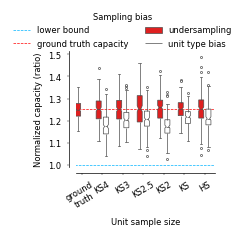

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5))

# LOAD/COMPUTE 1h34 for 0 bootstraps
igeom_df = pd.read_csv(IGEOM_SAMP)

# get entire ground truth capacity
gt_full_cap = igeom_df[igeom_df.Sorter == "ground_truth"].Capacity.unique()
print("full capacity:", np.mean(gt_full_cap))

# standardize name for plotting
igeom_df.loc[igeom_df.Sorter == "ground_truth", "Sorter"] = "ground\ntruth"

# set plot parameters
BOXPLOT_PMS = {
    "notch": True,
    "gap": 0.3,
    "width": 0.7,
    "linewidth": 0.5,
    "flierprops": {
        "marker": "o",
        "markerfacecolor": "w",
        "markersize": 1.5,
        "markeredgewidth": 0.5,
    },
}

# highlight lower bound
ax.hlines(xmin=-0.5, xmax=6.5, y=1, color=[0, 0.7, 1], linestyle="--")

# highlight full ground truth capacity
ax.hlines(xmin=-0.5, xmax=6.5, y=np.mean(gt_full_cap), color="red", linestyle="--")


# plot
ax = sns.boxplot(
    ax=ax,
    data=igeom_df,
    x="Sorter",
    y="Capacity",
    hue="Sampling scheme",
    hue_order=["random", "biased"],
    palette=["red", "white"],
    **BOXPLOT_PMS,
)

# legend
ax.set_ylabel("Normalized capacity (ratio)")
ax.set_xlabel("Unit sample size")
ax.legend(
    title="Sampling bias",
    labels=[
        "lower bound",
        "ground truth capacity",
        "undersampling",
        "unit type bias",
    ],
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(-0.5, 1.4),
    ncol=2,
)

# disconnect axis
ax.set_ylim(bottom=0.99)
ax.set_xlim(left=-0.3)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)

plt.xticks(rotation=30)

# save
utils.savefig(
    PROJ_PATH + "/figures/4_code/fig7D_capacity_vs_sampling_biases.svg",
)

### Hypothesis testing: degradation of capacity by undersampling

* effect of lower yield (sub-sampling) dissociated from the effect of unit type sampling bias.

In [11]:
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]

# standardize ground truth condition
print("Capacity degradation:\n")
igeom_df.loc[igeom_df.Sorter == "ground\ntruth", "Sorter"] = "ground_truth"

# measure degradation induced by sub-sampling
mean_change = []
for s_i in sorters:
    mean_change.append(get_mean_capacity_for_rand(s_i, igeom_df))
print("average capacity change:", np.mean(mean_change))


# standardize ground truth condition
igeom_df.loc[igeom_df.Sorter == "ground\ntruth", "Sorter"] = "ground_truth"

print("\nStats:\n")

# calculate one t-test stats
stats.get_ttest_gt_vs_rand_subset(igeom_df, "KS4")
stats.get_ttest_gt_vs_rand_subset(igeom_df, "KS3")
stats.get_ttest_gt_vs_rand_subset(igeom_df, "KS2.5")
stats.get_ttest_gt_vs_rand_subset(igeom_df, "KS2")
stats.get_ttest_gt_vs_rand_subset(igeom_df, "KS")
stats.get_ttest_gt_vs_rand_subset(igeom_df, "HS")

Capacity degradation:

KS4 mean capacity: 0.2505948953165553 vs full gt: 0.25127595712505335; changed by 0.0027104137470624888
KS3 mean capacity: 0.25114222662752517 vs full gt: 0.25127595712505335; changed by 0.0005322057034753618
KS2.5 mean capacity: 0.25509367960384033 vs full gt: 0.25127595712505335; changed by -0.015193345684430122
KS2 mean capacity: 0.2548649694574423 vs full gt: 0.25127595712505335; changed by -0.014283150578560114
KS mean capacity: 0.2539114599381467 vs full gt: 0.25127595712505335; changed by -0.010488479849991008
HS mean capacity: 0.2538197382518519 vs full gt: 0.25127595712505335; changed by -0.01012345612331134
average capacity change: -0.007807635464292456

Stats:

Entire ground truth vs KS4: t(199)=-0.13020694255924553, p=0.8964684847904607
Entire ground truth vs KS3: t(199)=-0.02527838198836682, p=0.9798455862613031
Entire ground truth vs KS2.5: t(199)=0.5819181141140706, p=0.5609512993442642
Entire ground truth vs KS2: t(199)=0.7150528204159435, p=0.474

### Hypothesis testing: degradation induced by sampling bias

* one-sample t-test

In [12]:
# measure degradation induced by sub-sampling
mean_change = []
for s_i in sorters:
    mean_change.append(get_mean_capacity_for_biased(s_i, igeom_df))
print("average capacity change:", np.mean(mean_change))

# standardize ground truth condition
igeom_df.loc[igeom_df.Sorter == "ground\ntruth", "Sorter"] = "ground_truth"

print("\nStats:\n")

# calculate t-test stats
stats.get_ttest_gt_vs_biased_subset(igeom_df, "KS4")
stats.get_ttest_gt_vs_biased_subset(igeom_df, "KS3")
stats.get_ttest_gt_vs_biased_subset(igeom_df, "KS2.5")
stats.get_ttest_gt_vs_biased_subset(igeom_df, "KS2")
stats.get_ttest_gt_vs_biased_subset(igeom_df, "KS")
stats.get_ttest_gt_vs_biased_subset(igeom_df, "HS")

KS4 mean capacity: 0.17680599194069924 vs full gt: 0.25127595712505335; changed by 0.2963672531044918
KS3 mean capacity: 0.2045553651795453 vs full gt: 0.25127595712505335; changed by 0.18593339561833386
KS2.5 mean capacity: 0.20881945825511394 vs full gt: 0.25127595712505335; changed by 0.1689636340686982
KS2 mean capacity: 0.17493151046858135 vs full gt: 0.25127595712505335; changed by 0.3038271051872957
KS mean capacity: 0.2134521263355489 vs full gt: 0.25127595712505335; changed by 0.15052705886492973
HS mean capacity: 0.2143606749318514 vs full gt: 0.25127595712505335; changed by 0.14691131859794368
average capacity change: 0.2087549609069488

Stats:

Entire ground truth vs KS4: t(199)=-16.144048213397507, p=1.85534345518184e-45
Entire ground truth vs KS3: t(199)=-10.076083668461294, p=2.0275582770638237e-21
Entire ground truth vs KS2.5: t(199)=-8.615450641356407, p=1.654959591256498e-16
Entire ground truth vs KS2: t(199)=-17.70162740548525, p=3.89782803666007e-52
Entire ground tr

### Contrast unit type distributions

* link sampling bias, capacity and unit types

In [7]:
# ground truth unit type distribution

# count the number of occurrences of each unique unit types
# in ground truth
# choose three features to describe units
df_gt = feat.get_gt_unit_features(SortingTrue)
unique_type_feat = ["layer", "synapse", "etype"]

# get unique unit types observed across the
# dataset
unique_type = df_gt.drop_duplicates()

# distribution of unique type
count_gt = feat.count_unit_type(
    df_gt[unique_type_feat],
    unique_type,
)

,type,count
0,"(L2/3, EXC, cADpyr)",342
1,"(L2/3, INH, dNAC)",4
2,"(L2/3, INH, cNAC)",6
3,"(L2/3, INH, bAC)",3
4,"(L2/3, INH, cACint)",11
5,"(L2/3, INH, bIR)",1
6,"(L2/3, INH, bNAC)",5
7,"(L1, INH, cACint)",2
8,"(L1, INH, cNAC)",4
9,"(L6, EXC, cADpyr)",658


In [24]:
# sample ground truth same as the spike sorters
# sample size matches the number of sorted single units
params = {
    "SortingTrue": SortingTrue,
    "quality_path2": quality_path,
    "dt": DT,
    "seed": 1,
}
k4 = igeom.sample_gt_based_on_sorting_distribution("KS4", Sortingk4, **params)
k3 = igeom.sample_gt_based_on_sorting_distribution("KS3", Sortingk3, **params)
k25 = igeom.sample_gt_based_on_sorting_distribution("KS2.5", Sortingk25, **params)
k2 = igeom.sample_gt_based_on_sorting_distribution("KS2", Sortingk2, **params)
ks = igeom.sample_gt_based_on_sorting_distribution("KS", Sortingks, **params)
hs = igeom.sample_gt_based_on_sorting_distribution("HS", Sortinghs, **params)

In [137]:
# (1m)
p_rnd_k4 = igeom.get_stats_of_gt_randomly_sampled_to_match_sorting_sample_size(
    "KS4", SortingTrue, quality_path, seeds=np.arange(0, N_BOOT, 1)
)

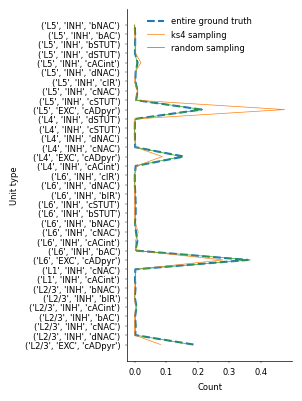

In [138]:
# setup plot
fig, ax = plt.subplots(1, 1, figsize=(3, 4))
xticks = np.arange(0, len(count_gt["type"]), 1)

# plot
ax.plot(
    count_gt["count"].values / sum(count_gt["count"].values),
    xticks,
    label="entire ground truth",
    linestyle="--",
    linewidth=1.5,
)
ax.plot(
    k4["counts"]["count"].values / sum(k4["counts"]["count"].values),
    xticks,
    label="ks4 sampling",
)
ax.plot(
    p_rnd_k4["stats"],
    xticks,
    label="random sampling",
)

# aesthetics
ax.set_yticks(xticks, count_gt["type"], rotation=0)
ax.set_xlabel("Count")
ax.set_ylabel("Unit type")
ax.legend(frameon=False, loc="upper right", bbox_to_anchor=(0.8, 1))
plt.tight_layout()

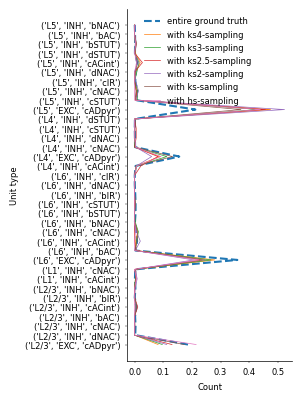

In [25]:
# setup plot
fig, ax = plt.subplots(1, 1, figsize=(3, 4))
xticks = np.arange(0, len(count_gt["type"]), 1)

# proportions
ax.plot(
    count_gt["count"].values / sum(count_gt["count"].values),
    xticks,
    label="entire ground truth",
    linestyle="--",
    linewidth=1.5,
)
ax.plot(
    k4["counts"]["count"].values / sum(k4["counts"]["count"].values),
    xticks,
    label="with ks4-sampling",
)
ax.plot(
    k3["counts"]["count"].values / sum(k3["counts"]["count"].values),
    xticks,
    label="with ks3-sampling",
)
ax.plot(
    k25["counts"]["count"].values / sum(k25["counts"]["count"].values),
    xticks,
    label="with ks2.5-sampling",
)
ax.plot(
    k2["counts"]["count"].values / sum(k2["counts"]["count"].values),
    xticks,
    label="with ks2-sampling",
)
ax.plot(
    ks["counts"]["count"].values / sum(ks["counts"]["count"].values),
    xticks,
    label="with ks-sampling",
)
ax.plot(
    hs["counts"]["count"].values / sum(hs["counts"]["count"].values),
    xticks,
    label="with hs-sampling",
)

# aesthetics
ax.set_yticks(xticks, count_gt["type"], rotation=0)
ax.set_xlabel("Count")
ax.set_ylabel("Unit type")
ax.legend(frameon=False, loc="upper right", bbox_to_anchor=(0.8, 1))
plt.tight_layout()